In [1]:
from skimage import io
import numpy as np
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from torch import nn
from numpy import pi
import torch.fft as fft
import torch.nn.functional as F
import time
import shutil
import pickle
from scipy import ndimage

from DS3Dplus.ds3d_utils import ImModelBase, ImModelBead, ImModelTraining, Sampling, calculate_cc, KDE_loss3D


# PSF characterization
read a bead zstack and do phase retrieval

In [26]:
### specify parameters
psf_param_dict = dict(
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    # objective
    M=100,  # magnification
    NA=1.49,  # NA
    n_immersion=1.518,  # refractive index of the immersion of the objective
    lamda=0.58,  # wavelength
    n_sample=1.33,  # refractive index of the sample
    f_4f=80e3,  # focal length of 4f system
    ps_camera=15.9,  # pixel size of the camera
    ps_BFP=20,  # pixel size at back focal plane
    NFP=0.0,  # location of the nominal focal plane, 0 for bead sample
    H=39,  # FOV/im size of the zstack, better to be add
    W=39,  # FOV/im size of the zstack, better to be add
    )
device = psf_param_dict['device']

### specify the zstack information
zstack_file = '.\dataset2\zscan_DH1_580nm_1um_-1um_50nm.tif'
z0, z1 = 1.0, -1.0  # maximum and minimum z, unit um
zn = 41  # how many steps

In [27]:
# im_model = ImModelBase(psf_param_dict)
# im_model.show_circs()
# im_model.model_demo(np.linspace(0, 0.5, 5))

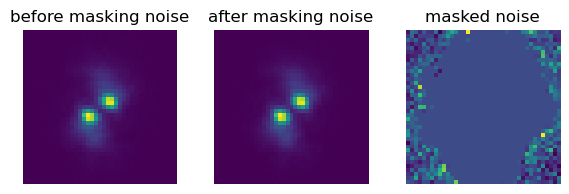

In [28]:
# image preprocessing: mask noise in zstack
zstack = io.imread(zstack_file)
zs = np.linspace(z0, z1, zn)

corner_size = max(7, int(0.1*zstack.shape[1]))  # you may adjust the corner size
patches = np.concatenate(
    (np.concatenate((zstack[:, :corner_size, :corner_size], zstack[:, :corner_size, -corner_size:]), axis=2),
     np.concatenate((zstack[:, -corner_size:, :corner_size], zstack[:, -corner_size:, -corner_size:]), axis=2)),
    axis=1)
means = np.mean(patches, axis=(1, 2), keepdims=True)
stds = np.std(patches, axis=(1, 2), keepdims=True)
# filtering mask
zstack = zstack - means
mask = (zstack > 1*stds)
# erode and dimate the mask
struct = ndimage.generate_binary_structure(rank=2, connectivity=1)  
mask = [ndimage.binary_dilation(ndimage.binary_erosion(mask[i, :, :], struct), struct) for i in range(mask.shape[0])]
# clean zstack
zstack_ = zstack * np.array(mask)

z_stack = zstack_/np.sum(zstack_, axis=(1, 2), keepdims=True)*1e4
z_photons = np.sum(z_stack, axis=(1, 2))

plt.figure(figsize=(7, 2))
zidx = 30
plt.subplot(131)
plt.imshow(zstack[zidx])
plt.title('before masking noise')
plt.axis('off')
plt.subplot(132)
plt.imshow(zstack_[zidx])
plt.title('after masking noise')
plt.axis('off')
plt.subplot(133)
plt.imshow(zstack[zidx]-zstack_[zidx])
plt.title('masked noise')
plt.axis('off')
plt.show()


blur sigma: 0.8617302179336548


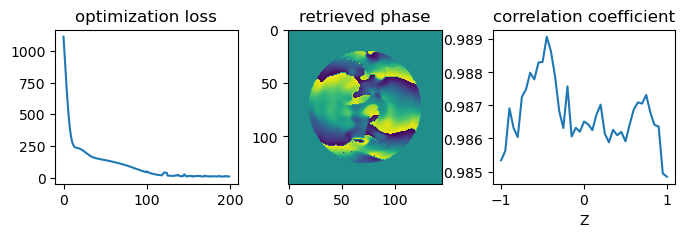

In [29]:
# phase retrieval
im_model_bead = ImModelBead(psf_param_dict)
im_model_bead.phase_mask.requires_grad_(True)
im_model_bead.g_sigma.requires_grad_(True)

num_zs = zstack.shape[0]
xyzps = np.zeros((num_zs, 4))
xyzps[:, 3] = z_photons
xyzps = torch.tensor(xyzps, device=device)
nfps = torch.tensor(zs, device=device).unsqueeze(1)

y = torch.tensor(z_stack, device=device) # measurement
optimizer = torch.optim.Adam([{'params': im_model_bead.phase_mask, 'lr': 0.1},
                              {'params': im_model_bead.g_sigma, 'lr': 0.06}
                              ])
epoch_loss = []
for i in range(100):
    fx = im_model_bead(xyzps, nfps)
    loss = torch.mean((fx-y)**2)
    loss = torch.nn.functional.mse_loss(fx, y)
    # loss = torch.mean(fx-y*torch.log(fx))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())
    

optimizer = torch.optim.Adam([{'params': im_model_bead.phase_mask, 'lr': 0.02},
                              {'params': im_model_bead.g_sigma, 'lr': 0.01}
                              ])
for i in range(100):
    with torch.no_grad():
        fx = im_model_bead(xyzps, nfps)
        model_psfs = fx.detach().cpu().numpy()
        ccs = calculate_cc(z_stack, model_psfs)
        ids = np.argsort(ccs)[:5]
        
    fx = im_model_bead(xyzps[ids], nfps[ids])
    loss = torch.nn.functional.mse_loss(fx, y[ids])
    # loss = torch.mean(fx-y[ids]*torch.log(fx))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())
    

with torch.no_grad():
    fx = im_model_bead(xyzps, nfps)
    model_psfs = fx.detach().cpu().numpy()
    ccs = calculate_cc(z_stack, model_psfs)

mask_rec = im_model_bead.phase_mask.detach().cpu().numpy()
mask_rec = np.angle(np.exp(1j*mask_rec))
g_sigma = im_model_bead.g_sigma.detach().item()
print(f'blur sigma: {g_sigma}')
plt.figure(figsize=(8, 2))
plt.subplot(131)
plt.plot(epoch_loss)
plt.title('optimization loss')
plt.subplot(132)
plt.imshow(mask_rec)
plt.title('retrieved phase')
# plt.axis('off')

plt.subplot(133)
plt.plot(zs, ccs)
plt.xlabel('Z')
plt.title('correlation coefficient')
plt.show()


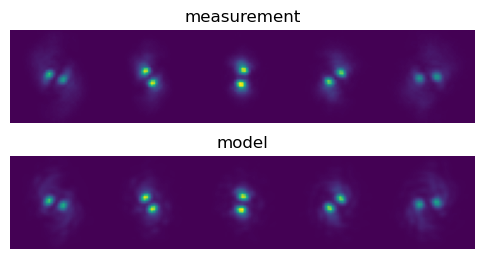

In [30]:
# show the performance of the phase retrieval above
z_stack_ = z_stack[::10]
model_psfs_ = model_psfs[::10]
z_stack_ = np.concatenate([z_stack_[i] for i in range(z_stack_.shape[0])], axis=1)
model_psfs_ = np.concatenate([model_psfs_[i] for i in range(model_psfs_.shape[0])], axis=1)

plt.figure(figsize=(6, 3))
plt.subplot(211)
plt.imshow(z_stack_)
plt.axis('off')
plt.title('measurement')
plt.subplot(212)
plt.imshow(model_psfs_)
plt.axis('off')
plt.title('model')
plt.show()

In [31]:
# save retrieved parameters
psf_param_dict['phase_mask'] = mask_rec
psf_param_dict['g_sigma'] = (0.9*g_sigma, 1.1*g_sigma)

# sio.savemat('laminB1_dh.mat', dict(mask=mask_rec))

# background subtraction
take every [group size] consecutive frames<br> 
minimum z-projection along the frame axis<br>
subtract each frame by the minimum map<br>

In [32]:
### spacify image folder and saving folder
im_folder = r'.\dataset2\laminB1_dense_dh'
save_folder = im_folder+'_br'  # path to save the images after background removal
group_size = 100  


In [33]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    im_files = sorted(os.listdir(im_folder))  # make sure the names are sortable
    n_ims = len(im_files)
    pointer = 0
    for i in range(n_ims//group_size):
        im_names = [im_files[pointer+j] for j in range(group_size)]
        im_stack = [io.imread(os.path.join(im_folder, im_files[pointer+j])) for j in range(group_size)]
        pointer += group_size
        im_stack = np.array(im_stack)
        im_stack = im_stack-np.min(im_stack, axis=0)

        for j in range(group_size):  # save
            io.imsave(os.path.join(save_folder, im_names[j]), im_stack[j], check_contrast=False)

    # remainder of n_ims/num
    im_stack = [io.imread(os.path.join(im_folder, im_files[-j])) for j in range(group_size)]
    im_stack = np.array(im_stack)
    im_min = np.min(im_stack, axis=0)
    for j in range(pointer, n_ims):
        im = io.imread(os.path.join(im_folder, im_files[j]))
        im = im-im_min
        io.imsave(os.path.join(save_folder, im_files[j]), im, check_contrast=False)
    
    print('Background subtraction is done.')
else:
    print('probably has been done.')
    # shutil.rmtree(save_folder)


Background subtraction is done.


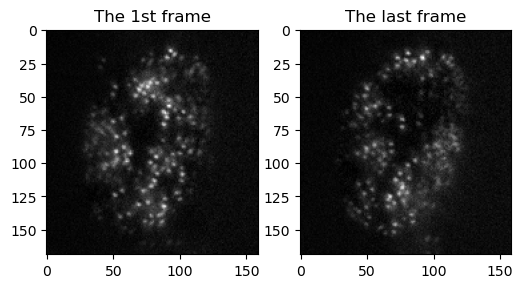

In [34]:
# show images after background subtraction
im_files = sorted(os.listdir(save_folder))
im1 = io.imread(os.path.join(save_folder, im_files[0]))
im_1 = io.imread(os.path.join(save_folder, im_files[-1]))
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(im1, cmap='gray')
plt.title('The 1st frame')
plt.subplot(122)
plt.imshow(im_1, cmap='gray')
plt.title('The last frame')
plt.show()

# training data generation
1, specify NFP and z-range to include reasonable PSF shape range<br>
2, SNR tuning by comparing a simulated training image to an experimental image<br>
3, generate training images

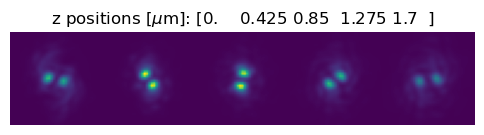

In [35]:
### specify PSF range
psf_param_dict['NFP'] = 1.1  # um
psf_param_dict['zrange'] = [0.0, 1.7]  # um
model = ImModelBase(psf_param_dict)
model.model_demo(np.linspace(psf_param_dict['zrange'][0], psf_param_dict['zrange'][1], 5))

In [36]:
### specify other parameters
td_param_dict = dict(
    # 3D volume corresponding to each 2D image input
    H=121, # size of training images
    W=121, # size of training images
    us_factor=1, # up-sampling factor, you may want to have finer xy voxel size
    D=40,  # voxel number in the specified z range
    
    # SNR
    Nsig_range=[15e4, 50e4],  # photon count range
    baseline=[600, 1400],
    read_std=[300, 600],  # standard deviation of readout noise
    non_uniform_noise_flag=True,  # non-uniform noise std due to non-uniform background 
    
    # molecule density
    num_particles_range=[1, 35],  # emitter count range
    psf_half_size=20,  # unit: pixel, periphery of no molecule, avoid PSF cropping
    
    # image normalization
    project_01 = False,  # 01 image normalization, not recommended
    
    # folder paths for training
    n_ims = 10000, # the number of training images
    td_folder = os.path.join(os.path.join(os.getcwd(), 'training_data'), 'laminB1'),
    training_result_path = os.path.join(os.getcwd(), 'training_results'),
    
    # other parameters
    bitdepth = 16, 
    blob_r=2,
    blob_sigma=0.65,
    blob_maxv=1000,
    
)

# merge and deduce some other parameters
param_dict = {**psf_param_dict, **td_param_dict}  
param_dict['HH'] = int(param_dict['H'] * param_dict['us_factor'])
param_dict['WW'] = int(param_dict['W'] * param_dict['us_factor'])
param_dict['buffer_HH'] = int(param_dict['psf_half_size'] * param_dict['us_factor'])
param_dict['buffer_WW'] = int(param_dict['psf_half_size'] * param_dict['us_factor'])
param_dict['ps_xy'] = param_dict['ps_camera'] / param_dict['M']
param_dict['vs_xy'] = param_dict['ps_xy'] / param_dict['us_factor']
param_dict['vs_z'] = ((param_dict['zrange'][1] - param_dict['zrange'][0]) / param_dict['D'])
print(f"vs_xy: {param_dict['vs_xy']} um, vs_z: {param_dict['vs_z']} um")

vs_xy: 0.159 um, vs_z: 0.042499999999999996 um


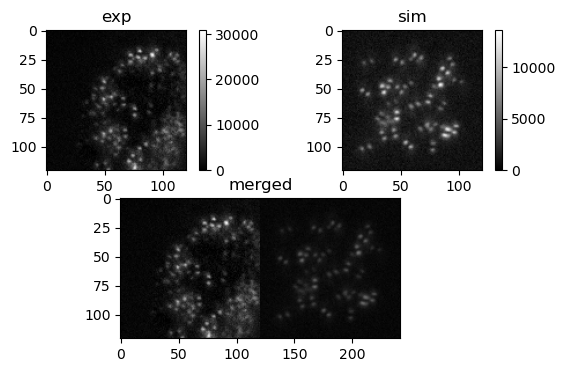

In [37]:
# check SNR by comparing to an experimental image
# if not good, go back to the last cell and tune parameters
model = ImModelTraining(param_dict)
sampling = Sampling(param_dict)
xyzps, _, _ = sampling.xyzp_batch()
im1_td = model(torch.from_numpy(xyzps).to(device)).cpu().numpy().astype(np.uint16)

hh = min([im1_td.shape[0], im_1.shape[0]])
ww = min([im1_td.shape[1], im_1.shape[1]])
im1_td = im1_td[:hh, :ww]
im_1_cropped = im_1[:hh, :ww]

plt.figure(figsize=(7, 4))
plt.subplot(221)
plt.title('exp')
plt.imshow(im_1_cropped, cmap='gray')
plt.colorbar()

plt.subplot(222)
plt.title('sim')
plt.imshow(im1_td, cmap='gray')
plt.colorbar()

plt.subplot(212)
plt.title('merged')
plt.imshow(np.concatenate((im_1_cropped, im1_td), axis=1), cmap='gray')
plt.show()

In [38]:
# generate training images
np.random.seed(66)
torch.manual_seed(88)

td_folder = param_dict['td_folder']
if os.path.exists(td_folder):  # delete the directory if it exists
    shutil.rmtree(td_folder)
x_folder = td_folder+'/x'
os.makedirs(x_folder)  # make the folder for training data

t0 = time.time()
# labels_dict for training
labels_dict = {}
labels_dict['volume_size'] = (param_dict['D'], param_dict['HH'], param_dict['WW'])
labels_dict['us_factor'] = param_dict['us_factor']
labels_dict['blob_r'] = sampling.blob_r  # radius of each 3D blob representing an emitter in space
labels_dict['blob_maxv'] = sampling.blob_maxv  # maximum value of blobs

ntrain = param_dict['n_ims']
for i in range(ntrain):
    xyzps, xyz_ids, blob3d = sampling.xyzp_batch()
    im = model(torch.from_numpy(xyzps).to(device)).cpu().numpy().astype(np.uint16)
    if param_dict['project_01']:
        im = ((im-im.min())/(im.max()-im.min()))

    x_name = str(i).zfill(5) + '.tif'
    io.imsave(os.path.join(x_folder, x_name), im, check_contrast=False)
    labels_dict[x_name] = (xyz_ids, blob3d)

    if i % (ntrain//10) == 0:
        print('Training Example [%d / %d]' % (i + 1, ntrain))
print('Training Example [%d / %d]' % (ntrain, ntrain))

y_file = os.path.join(td_folder, r'y.pickle')
with open(y_file, 'wb') as handle:
    pickle.dump(labels_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

param_file = os.path.join(td_folder, r'param.pickle')
with open(param_file, 'wb') as handle:
    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

t1 = time.time()
print(f'finished generating training data in {t1-t0}s.')

Training Example [1 / 10000]
Training Example [1001 / 10000]
Training Example [2001 / 10000]
Training Example [3001 / 10000]
Training Example [4001 / 10000]
Training Example [5001 / 10000]
Training Example [6001 / 10000]
Training Example [7001 / 10000]
Training Example [8001 / 10000]
Training Example [9001 / 10000]
Training Example [10000 / 10000]
finished generating training data in 86.08219647407532s.


# training

In [18]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from torch.optim import Adam
from DS3Dplus.ds3d_utils import MyDataset
from DS3Dplus.ds3d_utils import LON as Net
from DS3Dplus.training_utils import TorchTrainer

In [23]:
### specify training parameters
batch_size = 16
lr = 0.0005

In [24]:
# training
td_folder = param_dict['td_folder']
path_save = param_dict['training_result_path']
if not (os.path.isdir(path_save)):
    os.mkdir(path_save)

params_train = {'batch_size': batch_size, 'shuffle': True}
params_validate = {'batch_size': batch_size, 'shuffle': True}

x_folder = os.path.join(td_folder, 'x')
x_list = os.listdir(x_folder)
num_x = len(x_list)
with open(os.path.join(td_folder, 'y.pickle'), 'rb') as handle:
    labels = pickle.load(handle)

partition = {'train': x_list[:int(num_x*0.9)], 'validate': x_list[int(num_x*0.9):]}
train_ds = MyDataset(x_folder, partition['train'], labels)
train_dl = DataLoader(train_ds, **params_train)
validate_ds = MyDataset(x_folder, partition['validate'], labels)
validate_dl = DataLoader(validate_ds, **params_validate)

D, us_factor, maxv = labels['volume_size'][0], labels['us_factor'], labels['blob_maxv']
model = Net(D=D, us_factor=us_factor, maxv=maxv).to(device)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'# of trainable parameters: {n_params}')

optimizer = Adam(list(model.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True, min_lr=1e-6)  # verbose True
# my_loss_func = torch.nn.MSELoss()
my_loss_func = KDE_loss3D(sigma=0.5, device=device)
trainer = TorchTrainer(model, my_loss_func, optimizer, lr_scheduler=scheduler, device=device)

time_now = datetime.today().strftime('%m-%d_%H-%M')
net_file = 'net_'+time_now+'.pt'
checkpoints = dict(file_name=os.path.join(path_save, net_file),
                   net=Net(D=D, us_factor=us_factor, maxv=maxv),
                   state_dict=None,
                   note=' '
                   )

torch.backends.cudnn.benchmark = True
t0 = time.time()
fit_results = trainer.fit(train_dl, validate_dl, num_epochs=50, checkpoints=checkpoints, early_stopping=4)
t1 = time.time()
fit_file = 'fit_'+time_now+'.pickle'
with open(os.path.join(path_save, fit_file), 'wb') as handle:
    pickle.dump(fit_results, handle)
    
print(f'finished training in {t1-t0}s.')

# of trainable parameters: 317458
--- EPOCH 1/50 ---
train_batch (Loss 2.1033):  80%|██████████████████████████████████████████▋          | 453/563 [05:06<01:14,  1.48it/s]


KeyboardInterrupt: 